The following cell defines all central functions needed for training the SA_SN_DCGAN, computing metrics, and displaying images.

In [1]:
#imports
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras
from keras import layers, activations
from keras.initializers import RandomNormal
from keras.applications import InceptionV3
from keras.applications.inception_v3 import preprocess_input
import matplotlib.pyplot as plt
import cv2
from skimage.transform import resize
from scipy.linalg import sqrtm
import numpy as np
import os, time
from skimage.metrics import structural_similarity, peak_signal_noise_ratio

#Inception (IS) score metric
def IS_score(image_list, n_split=10, epsilon=1E-16):
    model = InceptionV3()
    scores = []
    n_partition = image_list.shape[0]//n_split
    for idx in range(n_split):
        subset = image_list[idx*n_partition:(idx+1)*n_partition].astype('float32')
        subset = np.asarray([resize(image, (299,299,3), 0) for image in subset])
        subset = preprocess_input(subset)
        prediction_yx = model.predict(subset,verbose=0)
        prediction_y = np.expand_dims(prediction_yx.mean(axis=0), 0)
        KL_div = prediction_yx * (np.log(prediction_yx + epsilon) - np.log(prediction_y + epsilon))
        sum_KL_div = KL_div.sum(axis=1)
        avg_KL_div = np.mean(sum_KL_div)
        is_score = np.exp(avg_KL_div)
        scores.append(is_score)
    avg_IS,stdv_IS = np.mean(scores),np.std(scores)
    return avg_IS,stdv_IS

#FID score metric
def FID_score(images_1, images_2):
    model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))
    images_1 = np.asarray([resize(image, (299,299,3), 0) for image in images_1])
    images_2 = np.asarray([resize(image, (299,299,3), 0) for image in images_2])
    activation_1,activation_2 = model.predict(images_1,verbose=0),model.predict(images_2,verbose=0)
    mu_1, sigma_1 = activation_1.mean(axis=0), np.cov(activation_1, rowvar=False)
    mu_2, sigma_2 = activation_2.mean(axis=0), np.cov(activation_2, rowvar=False)
    ss_difference = np.sum((mu_1-mu_2)**2.0)
    covariance_mean = sqrtm(sigma_1.dot(sigma_2))
    if np.iscomplexobj(covariance_mean):covariance_mean=covariance_mean.real
    fid_score = ss_difference + np.trace(sigma_1 + sigma_2 - 2.0*covariance_mean)
    return fid_score

#SSIM metric
def SSIM(images_1,images_2):
    total_SSIM = sum([structural_similarity(images_1[idx],images_2[idx],
                                            channel_axis=-1, data_range=255.0) for idx in range(len(images_1))])
    return total_SSIM/len(images_1)

#PSNR metric
def PSNR(images_1,images_2):
    total_PSNR = sum([peak_signal_noise_ratio(images_1[idx],images_2[idx]) for idx in range(len(images_1))])
    return total_PSNR/len(images_1)

#metrics helper function
def metrics(images_1,images_2):
    batch_size = len(images_2)

    total_avg_IS_score = 0
    total_std_IS_score = 0
    total_FID_score = 0
    total_SSIM_score = 0
    total_PSNR_score = 0

    #compute IS score averaged over batch size
    for idx in range(batch_size):
        avg,std = IS_score(images_1[idx])
        total_avg_IS_score+=avg
        total_std_IS_score+=std
    total_avg_IS_score/=batch_size
    total_std_IS_score/=batch_size

    #compute FID score averaged over batch size
    for idx in range(batch_size):
        total_FID_score+=FID_score(images_1[idx],images_2[idx])
    total_FID_score/=batch_size

    #compute SSIM score averaged over batch size
    for idx in range(batch_size):
        total_SSIM_score+=SSIM(images_1[idx],images_2[idx])
    total_SSIM_score/=batch_size

    #compute PSNR score averaged over batch size
    for idx in range(batch_size):
        total_PSNR_score+=PSNR(images_1[idx],images_2[idx])
    total_PSNR_score/=batch_size

    return total_avg_IS_score,total_std_IS_score,total_FID_score,total_SSIM_score,total_PSNR_score

#format generator output for display
def format_image(generator_output):
    unscaled_image = generator_output[0,:,:,:]
    scaled_image = (generator_output*127.5)+127.5
    clipped_image = np.clip(scaled_image,0.0,255.0)
    clipped_image/=255.0
    return clipped_image[0]

#display 9 images at once
def display_images():

    for idx in range(1,10):
        plt.subplot(3,3,idx)
        noise = tf.random.normal([1, 100])
        generated_image = generator(noise, training=False)
        img = format_image(generated_image)
        plt.imshow(img)
        plt.axis('off')
    plt.show()
    plt.clf()

#make generator following architecture outlined in paper
def make_generator_model():

    #input layer takes noise vector
    input_layer = keras.Input(shape=(100,))

    #fully connected layer without bias or activation to reshape input
    fcl = layers.Dense(4*4*3, use_bias=False,name='fcl')(input_layer)

    #reshape fully connected output
    reshape = layers.Reshape((4, 4, 3),name='reshape')(fcl)

    #transpose convolution block 1 using 512 filters, (mu=0,std=.02) normal initialization, batch normalization, and relu activation
    tconv1 = layers.Conv2DTranspose(512,3,padding='same',kernel_initializer=RandomNormal(mean=0.0, stddev=0.02),name='tconv1')(reshape)
    bnorm1 = layers.BatchNormalization()(tconv1)
    relu1 = layers.Activation(activations.relu)(bnorm1)

    #transpose convolution block 2 using 256 filters, (mu=0,std=.02) normal initialization, batch normalization, and relu activation
    tconv2 = layers.Conv2DTranspose(256,3,strides=2,padding='same',kernel_initializer=RandomNormal(mean=0.0, stddev=0.02),name='tconv2')(relu1)
    bnorm2 = layers.BatchNormalization()(tconv2)
    relu2 = layers.Activation(activations.relu)(bnorm2)

    #self attention layer
    attention = layers.MultiHeadAttention(1,256,kernel_initializer=RandomNormal(mean=0.0, stddev=0.02),name='attention')(relu2,relu2)

    #transpose convolution block 3 using 128 filters, (mu=0,std=.02) normal initialization, batch normalization, and relu activation
    tconv3 = layers.Conv2DTranspose(128,3,strides=2,padding='same',kernel_initializer=RandomNormal(mean=0.0, stddev=0.02),name='tconv3')(attention)
    bnorm3 = layers.BatchNormalization()(tconv3)
    relu3 = layers.Activation(activations.relu)(bnorm3)

    #transpose convolution block 4 using 64 filters, (mu=0,std=.02) normal initialization, batch normalization, and relu activation
    tconv4 = layers.Conv2DTranspose(64,3,strides=2,padding='same',kernel_initializer=RandomNormal(mean=0.0, stddev=0.02),name='tconv4')(tconv3)
    bnorm4 = layers.BatchNormalization()(tconv4)
    relu4 = layers.Activation(activations.relu)(bnorm4)

    #transpose convolution block 5 (output layer) using 3 filters, (mu=0,std=.02) normal initialization, batch normalization, and relu activation
    output_layer = layers.Conv2DTranspose(3,3,strides=2,padding='same',kernel_initializer=RandomNormal(mean=0.0, stddev=0.02),activation='tanh',name='output')(relu4)

    #assemble model
    model = keras.Model(inputs=input_layer, outputs=output_layer,name='generator')

    return model

#make discriminator following architecture outlined in paper
def make_discriminator_model():

    #input layer taking output from discriminator
    input_layer = keras.Input(shape=[64, 64, 3])

    #spectral normalization layer with 64 filters and leaky relu activation
    spec_norm = layers.SpectralNormalization(layers.Conv2D(64,3,strides=2,padding='same',name='spec_norm'))(input_layer)
    lrelu1 = layers.LeakyReLU(name='lrelu1')(spec_norm)

    #convolutional block 1 with 128 filters and leaky relu activation
    conv1 = layers.Conv2D(128,3,strides=2,padding='same',name='conv1')(lrelu1)
    bnorm1 = layers.BatchNormalization()(conv1)
    lrelu2 = layers.LeakyReLU(name='lrelu2')(bnorm1)

    #convolutional block 2 with 256 filters and leaky relu activation
    conv2 = layers.Conv2D(256,3,strides=2,padding='same',name='conv2')(lrelu2)
    bnorm2 = layers.BatchNormalization()(conv2)
    lrelu3 = layers.LeakyReLU(name='lrelu3')(conv2)

    #convolutional block 3 with 512 filters and leaky relu activation
    conv3 = layers.Conv2D(512,3,strides=2,padding='same',name='conv3')(lrelu3)
    bnorm3 = layers.BatchNormalization()(conv3)
    lrelu4 = layers.LeakyReLU(name='lrelu4')(conv3)

    #flatten convolutional block output
    flattened = layers.Flatten()(lrelu4)

    #spectral normalization output layer with (mu=0,std=.02) normal initialization, one unit and sigmoid activation (binary classification for real vs fake)
    output_layer = layers.SpectralNormalization(layers.Dense(1,kernel_initializer=RandomNormal(mean=0.0, stddev=0.02),activation='sigmoid',name='output_layer'))(flattened)

    #assemble model
    model = keras.Model(inputs=input_layer,outputs=output_layer,name='discriminator')

    return model

#discriminator loss takes real output (real images) and fake output (generator output)
#real output and fake output are the discriminators decisions on sets of real and fake images
def discriminator_loss(real_output, fake_output):

    #real loss is how far discriminator is from classifying real output from 1
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)

    #fake loss is how far discriminator is from classifying fake output from 0
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)

    #total discriminator loss is the sum of both losses
    total_loss = real_loss + fake_loss
    return total_loss

#generator loss takes fake output (the decisions from the descriminator on fake images)
def generator_loss(fake_output):
    #loss is how far the generator was from tricking the discriminator
    return cross_entropy(tf.ones_like(fake_output), fake_output)

#training function
@tf.function
def train_step(images):
    #generate batch of noise samples for the generator
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        #get fake images from generator
        generated_images = generator(noise, training=True)
        #get classifications from discriminator on real images
        real_output = discriminator(images, training=True)
        #get classifications from discriminator on fake images
        fake_output = discriminator(generated_images, training=True)
        #get generator loss using discriminators decisions on its output
        g_loss = generator_loss(fake_output)
        d_loss = discriminator_loss(real_output, fake_output)
        #get discriminator loss based on how well it discerned real from fake
    #get gradients of the generator
    gradients_of_generator = gen_tape.gradient(g_loss, generator.trainable_variables)
    #get gradients of the discriminator
    gradients_of_discriminator = disc_tape.gradient(d_loss, discriminator.trainable_variables)

    #update generator weights
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    #update discriminator weights
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return g_loss, d_loss

#training function
def train(dataset, epochs):
    losses = [[],[]]

    #for each epoch, apply train step and save generator and discriminator loss; time epoch
    for epoch in range(1,epochs+1):
        start_time = time.time()
        g_losses = []
        d_losses = []
        for image_batch in dataset:
            g_loss,d_loss = train_step(image_batch)
            g_losses.append(g_loss)
            d_losses.append(d_loss)
        losses[0].append(tf.math.reduce_mean(g_losses).numpy())
        losses[1].append(tf.math.reduce_mean(d_losses).numpy())
        epoch_time = round(time.time() - start_time)

        #display epoch information (time and losses)
        print("Epoch "+str(epoch)+": Generator loss: "+str(losses[0][-1])+"; Discriminator loss: "
              +str(losses[1][-1])+"; duration: "+str(epoch_time)+" seconds")

        #periodically display images following numbers in paper
        if (epoch==10 or epoch%50==0):
            print()
            display_images()
            print()

    return losses

#training and testing parameters
BATCH_SIZE = 64
IMG_SIZE = 64
TEST_BATCH_SIZE = 100
EPOCHS = 150
noise_dim = 100
test_size = 10000

The following cell defines the training loop and evaluation on animefacedataset

Found 30000 files.
Found 10000 files.



/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:780: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1: Generator loss: 4.6180463; Discriminator loss: 0.1749315; duration: 68 seconds
Epoch 2: Generator loss: 6.119162; Discriminator loss: 0.116988845; duration: 34 seconds
Epoch 3: Generator loss: 5.9106517; Discriminator loss: 0.08110975; duration: 34 seconds
Epoch 4: Generator loss: 6.783664; Discriminator loss: 0.10077741; duration: 33 seconds
Epoch 5: Generator loss: 6.6476274; Discriminator loss: 0.07898553; duration: 34 seconds
Epoch 6: Generator loss: 7.371941; Discriminator loss: 0.06548384; duration: 33 seconds
Epoch 7: Generator loss: 7.2018523; Discriminator loss: 0.06261445; duration: 34 seconds
Epoch 8: Generator loss: 8.018042; Discriminator loss: 0.06080961; duration: 34 seconds
Epoch 9: Generator loss: 8.055821; Discriminator loss: 0.052108895; duration: 33 seconds
Epoch 10: Generator loss: 8.4873495; Discriminator loss: 0.03858711; duration: 33 seconds



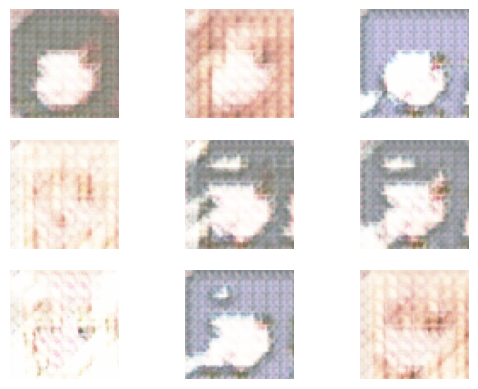


Epoch 11: Generator loss: 8.065739; Discriminator loss: 0.042301882; duration: 33 seconds
Epoch 12: Generator loss: 9.3439045; Discriminator loss: 0.044551775; duration: 33 seconds
Epoch 13: Generator loss: 8.957712; Discriminator loss: 0.032235984; duration: 34 seconds
Epoch 14: Generator loss: 9.373033; Discriminator loss: 0.0400783; duration: 34 seconds
Epoch 15: Generator loss: 8.972108; Discriminator loss: 0.053572904; duration: 33 seconds
Epoch 16: Generator loss: 8.433255; Discriminator loss: 0.0460046; duration: 34 seconds
Epoch 17: Generator loss: 8.850756; Discriminator loss: 0.03972162; duration: 34 seconds
Epoch 18: Generator loss: 9.283098; Discriminator loss: 0.044802047; duration: 33 seconds
Epoch 19: Generator loss: 9.245704; Discriminator loss: 0.03980187; duration: 33 seconds
Epoch 20: Generator loss: 9.491026; Discriminator loss: 0.043601107; duration: 33 seconds
Epoch 21: Generator loss: 9.555479; Discriminator loss: 0.027982995; duration: 33 seconds
Epoch 22: Gene

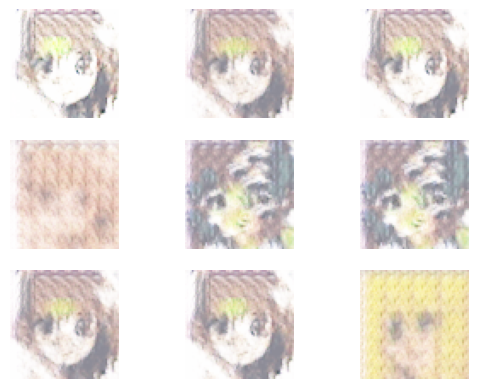


Epoch 51: Generator loss: 11.836203; Discriminator loss: 0.037038017; duration: 34 seconds
Epoch 52: Generator loss: 11.876102; Discriminator loss: 0.046867225; duration: 33 seconds
Epoch 53: Generator loss: 11.348983; Discriminator loss: 0.030824082; duration: 33 seconds
Epoch 54: Generator loss: 10.849885; Discriminator loss: 0.02704775; duration: 33 seconds
Epoch 55: Generator loss: 12.789808; Discriminator loss: 0.038006403; duration: 34 seconds
Epoch 56: Generator loss: 13.118368; Discriminator loss: 0.039410967; duration: 33 seconds
Epoch 57: Generator loss: 12.644054; Discriminator loss: 0.029770553; duration: 33 seconds
Epoch 58: Generator loss: 9.659646; Discriminator loss: 0.016600722; duration: 33 seconds
Epoch 59: Generator loss: 13.555257; Discriminator loss: 0.03593095; duration: 33 seconds
Epoch 60: Generator loss: 15.07741; Discriminator loss: 0.051865462; duration: 33 seconds
Epoch 61: Generator loss: 11.2033615; Discriminator loss: 0.026294244; duration: 33 seconds
E

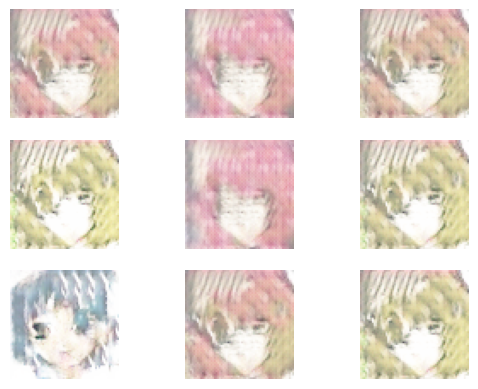


Epoch 101: Generator loss: 14.063422; Discriminator loss: 0.025920736; duration: 33 seconds
Epoch 102: Generator loss: 12.396983; Discriminator loss: 0.017978696; duration: 33 seconds
Epoch 103: Generator loss: 12.412019; Discriminator loss: 0.013626896; duration: 33 seconds
Epoch 104: Generator loss: 14.67735; Discriminator loss: 0.023188788; duration: 33 seconds
Epoch 105: Generator loss: 16.48489; Discriminator loss: 0.024399588; duration: 33 seconds
Epoch 106: Generator loss: 18.82152; Discriminator loss: 0.04481572; duration: 33 seconds
Epoch 107: Generator loss: 17.081715; Discriminator loss: 0.035277735; duration: 33 seconds
Epoch 108: Generator loss: 14.924496; Discriminator loss: 0.03958002; duration: 33 seconds
Epoch 109: Generator loss: 16.529202; Discriminator loss: 0.030939171; duration: 34 seconds
Epoch 110: Generator loss: 12.641961; Discriminator loss: 0.02049453; duration: 33 seconds
Epoch 111: Generator loss: 16.062387; Discriminator loss: 0.028434997; duration: 33 s

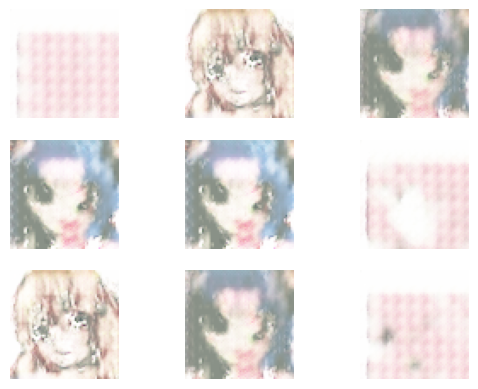



Animeface dataset final losses:
Generator: 19.209715
Discriminator: 0.02994278



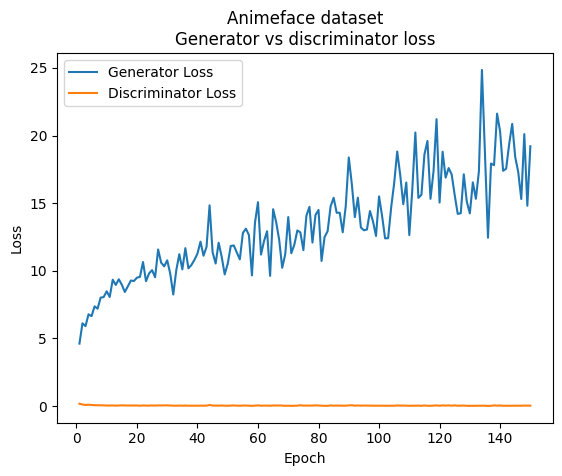

Animeface dataset metrics:
IS score: 1.0007520914077759
FID score: 366.1350093644388
SSIM score: 0.98635155
PSNR score: 9.516572722649078


<Figure size 640x480 with 0 Axes>

In [2]:
#animeface dataset train directory
animeface_train_dir = "/content/drive/MyDrive/animefacedataset/train"
#load animeface dataset training images
train_dataset = keras.utils.image_dataset_from_directory(
    animeface_train_dir, label_mode=None, image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE
)
#normalize images
train_dataset = train_dataset.map(lambda x: x / 255.0)

#animeface dataset test directory
animeface_test_dir = "/content/drive/MyDrive/animefacedataset/test"
#load animeface dataset training images
test_dataset = keras.utils.image_dataset_from_directory(
    animeface_test_dir, label_mode=None, image_size=(IMG_SIZE, IMG_SIZE), batch_size=TEST_BATCH_SIZE
)
#normalize images
test_dataset = test_dataset.map(lambda x: x / 255.0)

print()

#cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

#define generator and discriminator optimizers
#Adam with learning rate .0002 as described in paper
generator_optimizer = tf.keras.optimizers.Adam(.0002)
discriminator_optimizer = tf.keras.optimizers.Adam(.0002)

#assemble generator
generator = make_generator_model()
#assemble discriminator
discriminator = make_discriminator_model()

#train combined DCGAN
history = train(train_dataset, EPOCHS)

#save generator weights; please change to appropriate path if retraining
generator.save_weights('/content/sample_data/animefacedataset_generator.weights.h5')
#save discriminator weights; please change to appropriate path if retraining
discriminator.save_weights('/content/sample_data/animefacedataset_discriminator.weights.h5')

#obtain ending losses
animeface_g_loss_final = history[0][-1]
animeface_d_loss_final = history[1][-1]

#print ending losses
print()
print("Animeface dataset final losses:")
print("Generator: "+str(animeface_g_loss_final))
print("Discriminator: "+str(animeface_d_loss_final))
print()

#save training curves
animeface_training_curves = history

#plot training loss for generator and discriminator
epoch_indexes = [idx+1 for idx in range(EPOCHS)]
plt.plot(epoch_indexes,history[0],label='Generator Loss')
plt.plot(epoch_indexes,history[1],label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Animeface dataset\nGenerator vs discriminator loss")
plt.legend()
plt.show()
plt.clf()

test_generated_images = []

#generate test images using trained model
for i in range(TEST_BATCH_SIZE):
    test_noise = tf.random.normal([test_size//TEST_BATCH_SIZE, noise_dim])
    generated_images = generator(test_noise, training=False).numpy()
    formatted_images = []
    for img in generated_images:
        reshaped = np.reshape(img,(1,64,64,3))
        formatted_images.append(format_image(reshaped))
    test_generated_images.append(formatted_images)

test_generated_images = np.asarray(test_generated_images)
test_real_images = np.asarray([img.numpy() for img in test_dataset])
test_real_images = np.clip(test_real_images,0.0,255.0)

#obtain animeface metrics
animeface_metrics = metrics(test_generated_images,test_real_images)
animeface_avg_IS_score = float(animeface_metrics[0])
animeface_FID_score = animeface_metrics[2]
animeface_SSIM_score = animeface_metrics[3]
animeface_PSNR_score = animeface_metrics[4]

#print animeface metrics
print("Animeface dataset metrics:")
print("IS score: "+str(animeface_avg_IS_score))
print("FID score: "+str(animeface_FID_score))
print("SSIM score: "+str(animeface_SSIM_score))
print("PSNR score: "+str(animeface_PSNR_score))